# Google Ads Keyword planning project
### 55703 Text Minning for Business Applications
### Chen Portsia

The goal of the project is to assist in searching queries in the Google Ads keyword planner and choosing the best queries according to the marketing strategy by classifying the queries into search intent.

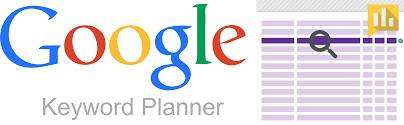 

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Geting the Google Ads Keyword Planner API

In [2]:
from google.ads.googleads.client import GoogleAdsClient
from google.ads.googleads.errors import GoogleAdsException
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

path = r'C:\Users\naama\Desktop\Chen\לימודים\כריית טקסט\FinalProject\google-ads.yaml'

try:
    # Load the Google Ads client
    google_ads_client = GoogleAdsClient.load_from_storage(path)
    logging.info("Google Ads client loaded successfully.")
except GoogleAdsException as ex:
    logging.error(f"Google Ads API error: {ex.error}")
except Exception as ex:
    logging.error(f"An error occurred: {ex}")


INFO:root:Google Ads client loaded successfully.


<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Search the Google Ads Keyword Planner

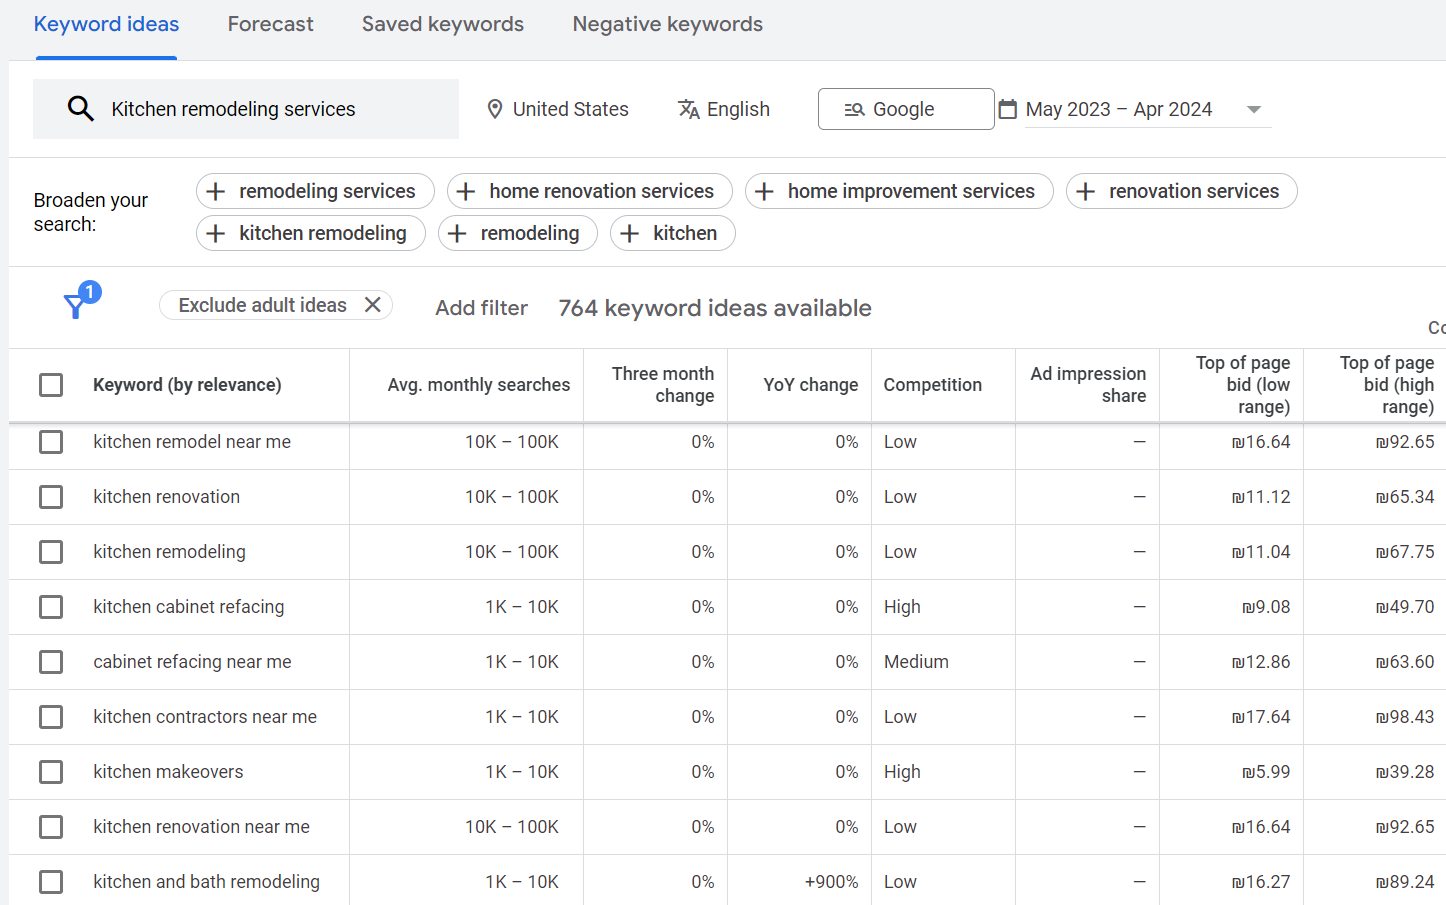

#### In this use case we use the search query <b>"Kitchen remodeling services"</b> 

In [3]:
def get_related_keywords(keyword, google_ads_client, customer_id):
    try:
        keyword_plan_idea_service = google_ads_client.get_service("KeywordPlanIdeaService")
        keyword_plan_idea_request = google_ads_client.get_type("GenerateKeywordIdeasRequest")

        # Set the customer ID (without dashes).
        keyword_plan_idea_request.customer_id = customer_id

        # Set the language and location using resource names.
        keyword_plan_idea_request.language = "languageConstants/1000"  # English
        keyword_plan_idea_request.geo_target_constants = ["geoTargetConstants/2840"]  # United States

        # Exclude adult keywords.
        keyword_plan_idea_request.include_adult_keywords = False

        # Set up the keyword seed (not URL seed).
        keyword_seed = google_ads_client.get_type("KeywordSeed")
        keyword_seed.keywords.append(keyword)
        keyword_plan_idea_request.keyword_seed = keyword_seed

        # Make the API request to fetch keyword ideas.
        response = keyword_plan_idea_service.generate_keyword_ideas(request=keyword_plan_idea_request)

        # Process the response and extract keyword suggestions along with their volumes.
        related_keywords = []
        for idea in response.results:
            if idea.text != keyword:
                related_keywords.append({
                    "keyword": idea.text,
                    "monthly_search_volume": idea.keyword_idea_metrics.avg_monthly_searches
                })
        return related_keywords

    except GoogleAdsException as ex:
        print(f"Request with ID '{ex.request_id}' failed with status '{ex.error.code().name}' and includes the following errors:")
        for error in ex.failure.errors:
            print(f'\tError with message "{error.message}".')
            if error.location:
                for field_path_element in error.location.field_path_elements:
                    print(f'\t\tOn field: {field_path_element.field_name}')
        return []

customer_id = '2684440076'
search_keyword = "Kitchen remodeling services"
related_keywords = get_related_keywords(search_keyword, google_ads_client, customer_id)
print('Number of related keywords:', len(related_keywords))
print('Related keywords sample:', '\n')
for keyword in related_keywords[:10]:
    print(keyword)

INFO:google.ads.googleads.client:Request made: ClientCustomerId: 2684440076, Host: googleads.googleapis.com, Method: /google.ads.googleads.v16.services.KeywordPlanIdeaService/GenerateKeywordIdeas, RequestId: YxjS7YdxieHVnhjzgFdyIg, IsFault: False, FaultMessage: None


Number of related keywords: 623
Related keywords sample: 

{'keyword': 'kitchen remodeling services', 'monthly_search_volume': 1300}
{'keyword': 'kitchen remodel near me', 'monthly_search_volume': 60500}
{'keyword': 'kitchen renovation', 'monthly_search_volume': 27100}
{'keyword': 'kitchen remodeling', 'monthly_search_volume': 135000}
{'keyword': 'kitchen cabinet refacing', 'monthly_search_volume': 6600}
{'keyword': 'cabinet refacing near me', 'monthly_search_volume': 6600}
{'keyword': 'kitchen contractors near me', 'monthly_search_volume': 5400}
{'keyword': 'kitchen makeovers', 'monthly_search_volume': 14800}
{'keyword': 'kitchen renovation near me', 'monthly_search_volume': 60500}
{'keyword': 'kitchen and bath remodeling', 'monthly_search_volume': 9900}


First quartile: 10.0


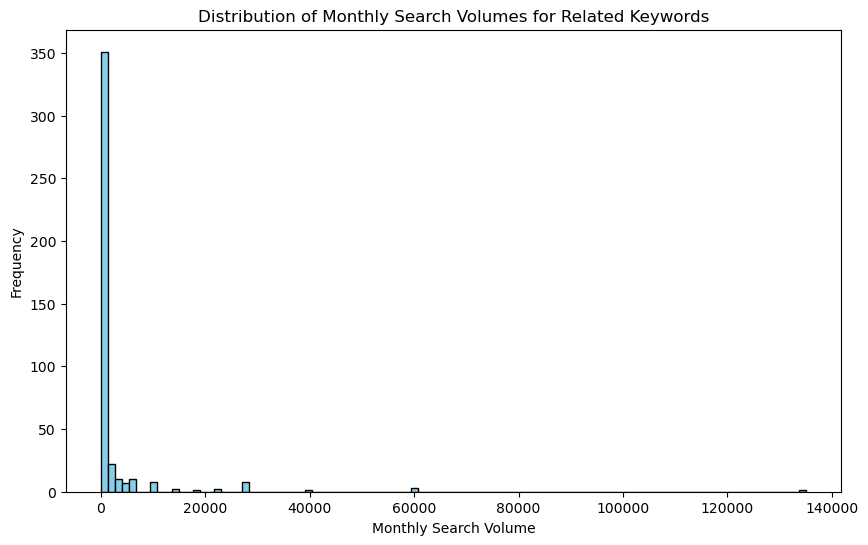

In [4]:
# Plot of volume distribution
import matplotlib.pyplot as plt
import numpy as np

# Extract keyword and volume data
keywords = [kw["keyword"] for kw in related_keywords]
volumes = [kw["monthly_search_volume"] for kw in related_keywords]

print('First quartile:', np.percentile(volumes, 25))

# Filter volumes that lower then the first quartile
volumes = [volume for volume in volumes if volume > np.percentile(volumes, 25)]

# Plot the distribution of search volumes
plt.figure(figsize=(10, 6))
plt.hist(volumes, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Monthly Search Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Search Volumes for Related Keywords')
plt.show()

Most of the words have a low volume of monthly searches.<br>  If I want to invest the marketing budget properly, I might choose the high-volume keywords.

In [5]:
# Queries with less then 1000 monthly search volume
low_volume_queries = [kw["keyword"] for kw in related_keywords if kw["monthly_search_volume"] < 1000]
print('Number of low volume queries:', len(low_volume_queries))
print('Number of filtered queries:', len(related_keywords) - len(low_volume_queries), '\n')
print('Sample of low volume queries:')
low_volume_queries[:10]

Number of low volume queries: 524
Number of filtered queries: 99 

Sample of low volume queries:


['kitchen makeovers near me',
 'affordable kitchen remodel near me',
 'kitchen restoration',
 'kitchen renovation contractors near me',
 'kitchen counter top replacement',
 'countertop replacement near me',
 'kitchen and bath contractors near me',
 'kitchen refacing cost',
 'cheap kitchen renovations',
 'kitchen and bath remodeling companies near me']

#### After filtering the queries with the highest search volume, I get a small number of queries. <br> One way of not losing the low-volume queries is to shuffle them logically and search the new terms again in the Keyword Planner to find better queries. <br> One example would be: <b>'kitchen makeovers near me'</b> might turn into <b>'makeovers kitchen near me'</b> <br><br> First step of shuffling the queries is to look for bigrams so the shuffling will make more sense in terms of the discussed subject. 

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def get_most_common_bigrams(queries, top_n=10):
    # Initialize the CountVectorizer with bigram extraction
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    
    # Fit and transform the queries
    X = vectorizer.fit_transform(queries)
    
    # Sum up the counts of each bigram
    bigram_counts = X.sum(axis=0).A1
    
    # Get the bigram feature names
    bigrams = vectorizer.get_feature_names_out()
    
    # Combine bigrams and their counts into a list of tuples
    bigram_freq = list(zip(bigrams, bigram_counts))
    
    # Sort by frequency and get the top_n bigrams
    bigram_freq_sorted = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
    
    return bigram_freq_sorted[:top_n]

most_common_bigrams = [term[0] for term in get_most_common_bigrams(keywords, top_n=10)]
print('Most common bigrams:', '\n')
most_common_bigrams[:10]

Most common bigrams: 



['kitchen remodeling',
 'kitchen renovation',
 'near me',
 'kitchen and',
 'kitchen remodel',
 'kitchen renovations',
 'and bath',
 'and bathroom',
 'bath remodeling',
 'kitchen bath']

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Shuffel the low-volume queries

#### I choose to shuffle the queries by changing the positions of the word parts found by Spacy

In [16]:
import spacy
import random

# Load Spacy's English tokenizer, POS tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

fixed_words = ["and", "&", "of", "on", "near", "me", "to", "with", "for", "in", "at", "from", "by"]

def shuffle_query(query, common_bigrams):
    # Parse the sentence using the loaded NLP model
    doc = nlp(query)
    
    # Extract the tokens and their POS tags
    tokens = [(token.text, token.pos_) for token in doc]
    
    # Find and mark positions of common bigrams
    bigram_positions = []
    for bigram in common_bigrams:
        bigram_tokens = bigram.split()
        for i in range(len(tokens) - 1):
            if tokens[i][0] == bigram_tokens[0] and tokens[i + 1][0] == bigram_tokens[1]:
                bigram_positions.append((i, i + 1))
    
    # Separate the tokens based on POS tags and bigram positions
    to_shuffle = []
    fixed_positions = {}
    
    i = 0
    while i < len(tokens):
        if any(i == pos[0] for pos in bigram_positions):
            fixed_positions[i] = tokens[i][0]
            fixed_positions[i + 1] = tokens[i + 1][0]
            i += 2
        elif tokens[i][0].lower() in fixed_words:
            fixed_positions[i] = tokens[i][0]
            i += 1
        else:
            to_shuffle.append(tokens[i])
            i += 1
    
    # Shuffle each category separately
    random.shuffle(to_shuffle)
    
    # Reconstruct the query while maintaining the position of fixed words
    shuffled_query = []
    shuffle_index = 0
    
    for i in range(len(tokens)):
        if i in fixed_positions:
            shuffled_query.append(fixed_positions[i])
        else:
            if shuffle_index < len(to_shuffle):
                shuffled_query.append(to_shuffle[shuffle_index][0])
                shuffle_index += 1
    
    shuffled_query = ' '.join(shuffled_query)
    
    # Clean up any double spaces
    shuffled_query = ' '.join(shuffled_query.split())
    
    return shuffled_query

def shuffle_queries(queries):
    common_bigrams = [term[0] for term in get_most_common_bigrams(queries, top_n=10)]
    return [shuffle_query(query, common_bigrams) for query in queries]

shuffled_queries = shuffle_queries(low_volume_queries)

shuffled_queries = [query for query in shuffled_queries if query not in low_volume_queries]

print('Number of shuffled queries:', len(shuffled_queries), '\n')
shuffled_queries[:10]

Number of shuffled queries: 260 



['restoration kitchen',
 'replacement top kitchen counter',
 'kitchen and contractors bath near me',
 'cost refacing kitchen',
 'cabinet kitchen renovation',
 'kitchen up tune near me',
 'restoration kitchen near me',
 'bath kitchen remodel near me',
 'refurbishing cabinet kitchen near me',
 'kitchen refacing companies cabinet near me']

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Filter the grammatically incorrect queries
#### I used TextBlob to filter incorrect queries shuffled by Spacy

In [18]:
from textblob import TextBlob

def is_grammatically_correct(query):
    # Create a TextBlob object
    blob = TextBlob(query)
    # Get the corrected version of the query
    corrected_query = str(blob.correct())
    # If the corrected query is the same as the original, it's grammatically correct
    return corrected_query.lower() == query.lower()

def filter_grammatically_incorrect_queries(queries):
    # Filter queries to only include those that are grammatically correct
    return [query for query in queries if is_grammatically_correct(query)]
    
filtered_queries = filter_grammatically_incorrect_queries(shuffled_queries)

incorrect_queries = [query for query in shuffled_queries if query not in filtered_queries]  

print('Number of filtered queries:', len(filtered_queries), '\n')
for i in filtered_queries[:10]:
    print(i)
print('\n')

print('Number of incorrect queries:', len(incorrect_queries), '\n')
for i in incorrect_queries[:10]:
    print(i)

Number of filtered queries: 103 

restoration kitchen
replacement top kitchen counter
kitchen and contractors bath near me
cabinet kitchen renovation
kitchen up tune near me
restoration kitchen near me
refurbishing cabinet kitchen near me
replacement kitchen countertop near me
kitchen contractors commercial near me
contractors kitchen best near me


Number of incorrect queries: 157 

cost refacing kitchen
bath kitchen remodel near me
kitchen refacing companies cabinet near me
solutions kitchen remodeling us
remodel cabinet near me
my remodeling kitchen
refacing companies kitchen near me
your kitchen remodeling
companies kitchen remodel best
companies kitchen makeover best


<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Extend the keyword list by searching all new shuffled queries again in the Keyword Planner
#### Yet, filtering the monthly volume.<br>I changed the function in order to handle multiple requests.

In [24]:
import time
from google.ads.googleads.errors import GoogleAdsException

def get_related_keywords(query, google_ads_client, customer_id, retries=3):
    keyword_plan_idea_service = google_ads_client.get_service("KeywordPlanIdeaService")
    
    keyword_seed = google_ads_client.get_type("KeywordSeed")
    keyword_seed.keywords.append(query)
    
    keyword_plan_idea_request = google_ads_client.get_type("GenerateKeywordIdeasRequest")
    keyword_plan_idea_request.customer_id = customer_id
    keyword_plan_idea_request.keyword_seed = keyword_seed
    
    for attempt in range(retries):
        try:
            # Make the API request to fetch keyword ideas.
            response = keyword_plan_idea_service.generate_keyword_ideas(request=keyword_plan_idea_request)
            
            # Process the response and extract keyword suggestions along with their volumes.
            related_keywords = []
            for result in response:
                keyword = result.text
                volume = result.keyword_idea_metrics.avg_monthly_searches
                related_keywords.append({"keyword": keyword, "monthly_search_volume": volume})
                
            return related_keywords
        except GoogleAdsException as ex:
            if ex.error.code() == grpc.StatusCode.RESOURCE_EXHAUSTED:
                if attempt < retries - 1:
                    print("Quota exceeded, retrying in 4 seconds...")
                    time.sleep(4)  # Wait before retrying
                else:
                    raise
            else:
                raise

# Example usage:
additional_keywords = []

for query in filtered_queries:
    try:
        a = get_related_keywords(query, google_ads_client, customer_id)
        # Filter by volume
        a = [kw["keyword"] for kw in a if kw["monthly_search_volume"] > 1000]
        additional_keywords.extend(a)
    except GoogleAdsException as e:
        print(f"Error fetching keywords for query '{query}': {e}")

In [25]:
print('Number of additional keywords:', len(additional_keywords), '\n')
additional_keywords[:10]

Number of additional keywords: 256 



['restoration kitchen',
 'cabinet restoration',
 'refurbish kitchen cabinets',
 'kitchen cabinet restoration',
 'refurbish cabinets kitchen',
 'restoration kitchen and wine',
 'countertop replacements',
 'replacing kitchen counter tops',
 'laminate kitchen countertop sheet',
 'kitchen and bath remodeling contractors near me']

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Filter the duplicate and save the keyword list

In [26]:
# Combine full list of keywords
all_keywords = list(set(filtered_queries + additional_keywords))
# Save the list of unique keywords to text file
search_keyword = "Kitchen remodeling services"
search_keyword = search_keyword.replace(" ", "_")
with open('unique_keywords_' + search_keyword + '.txt', 'w') as f:
    for keyword in all_keywords:
        f.write(keyword + '\n')

print('Total number of unique keywords:', len(all_keywords), '\n')
random.sample(all_keywords, 20)

Total number of unique keywords: 255 



['kitchen new contractors',
 'kitchen remodeling contractors near me',
 'contractors kitchen custom near me',
 'a planning kitchen renovation',
 'kitchen & bath remodeling',
 'kitchen bath renovations',
 'redo cabinets in kitchen',
 'top kitchen renovation',
 'kitchen and bath contractor',
 'bathroom kitchen contractors',
 'contractors kitchen best near me',
 'removing a kitchen sink',
 'upgraded kitchen cabinets',
 'kitchen sunroom addition',
 '$ 50000 kitchen renovation',
 'replacing kitchen countertops',
 'removing paint from kitchen cabinets',
 'small kitchen renovation budget',
 'cost of replacing kitchen countertops',
 'kitchen bathroom remodel contractors']

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-info-circle"></i> Search intent classification

Search intent refers to the purpose behind a user's query on a search engine. Understanding search intent is crucial for optimizing content to meet users' needs and improve search engine rankings. There are several types of search intent, primarily categorized into four main types:

<b>Informational Intent:</b><br>
&emsp; Goal: The user is seeking information or answers to specific questions.<br>
&emsp; Examples: "What is the capital of France?", "How to bake a cake", "Benefits of yoga".<br>
&emsp; Content Focus: Articles, blog posts, tutorials, how-to guides, and educational content.

<b>Navigational Intent:</b><br>
&emsp; Goal: The user wants to go to a specific website or find a particular webpage.<br>
&emsp; Examples: "Facebook login", "YouTube", "New York Times homepage".<br>
&emsp; Content Focus: Homepages, login pages, specific sections of a website.

<b>Transactional Intent:</b><br>
&emsp; Goal: The user intends to make a purchase or complete a transaction.<br>
&emsp; Examples: "Buy iPhone 13", "Subscribe to Netflix", "Cheap flights to Paris".<br>
&emsp; Content Focus: Product pages, service pages, pricing information, calls to action, e-commerce platforms.
  
<b>Commercial Investigation:</b><br>
&emsp; Goal: The user is researching products or services and considering a purchase but hasn't made a final decision.<br>
&emsp; Examples: "Best laptops 2024", "Nike vs Adidas running shoes", "Top smartphones under $500".<br>
&emsp; Content Focus: Reviews, comparison articles, product recommendations, buying guides.

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Load the OpenAI keys

In [28]:
from openai import OpenAI

open_ai_key_path = r"C:\Users\naama\Desktop\Chen\Secret keys\OpenAI_API.txt"
OPENAI_API_KEY = open(open_ai_key_path, 'r').read()

client = OpenAI(
    api_key = OPENAI_API_KEY
)

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Load the keyword list and set true label evaluetion set

#### I manually tagged sample of 20 queries in order to evaluate the models

In [27]:
import pandas as pd

# Load List of unique keywords
search_keyword = "Kitchen remodeling services"
search_keyword = search_keyword.replace(" ", "_")
with open('unique_keywords_' + search_keyword + '.txt', 'r') as f:
    keywords_list = f.read().splitlines()
    print(f'{len(keywords_list)} of keywords loaded from file.')
    
training_queries_labels = {
    'bathroom kitchen remodel': 'Commercial',
    'countertop remodeling': 'Commercial',
    'bath and kitchen contractors near me': 'Transactional',
    'kitchen remodeling average cost': 'Informational',
    'intact kitchen & renovations': 'Commercial',
    'kitchen renovation': 'Commercial',
    'luxury bathroom & kitchen renovations': 'Commercial',
    'kitchen makeover companies near me': 'Transactional',
    'artis kitchen and bath remodeling': 'Navigational',
    'outdoor kitchen additions': 'Commercial',
    'gta kitchen remodeling': 'Commercial',
    'kitchen bathroom contractors': 'Commercial',
    'companies that reface kitchen cabinets': 'Commercial',
    'amazing kitchen remodels': 'Informational',
    'cost of refurbishing kitchen cabinets': 'Informational',
    'kitchen renovation for small kitchen': 'Informational',
    'affordable kitchen and bath remodeling': 'Commercial',
    'full kitchen remodeling': 'Commercial',
    'local kitchen and bath remodelers': 'Commercial',
    'cabinet kitchen makeover': 'Commercial'
}

training_queries = list(training_queries_labels.keys())

255 of keywords loaded from file.


<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Capitalize Names in the queries
#### In order to assist the classification mode in better classifying users' search intent

In [29]:
# Find names using spacy and replace them with a Capitalized version
import spacy

nlp = spacy.load("en_core_web_lg")

def capitalize_names(query):
    doc = nlp(query)
    capitalized_query = query
    offset = 0  # To keep track of changes in length of the string due to replacements
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'ORG', 'GPE']:
            # Capitalize each part of the name
            capitalized_name = ' '.join([part.capitalize() for part in ent.text.split()])
            start = ent.start_char + offset
            end = ent.end_char + offset
            capitalized_query = capitalized_query[:start] + capitalized_name + capitalized_query[end:]
            offset += len(capitalized_name) - len(ent.text)
    return capitalized_query

training_queries = [capitalize_names(query) for query in training_queries]

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Choose the method for zero-shot classification
I chose a number of models to compare:
- 'facebook/bart-large-mnli'
- 'knowledgator/comprehend_it-base'
- 'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli'
- 'sileod/deberta-v3-small-tasksource-nli'
- 'MoritzLaurer/deberta-v3-large-zeroshot-v2.0'

And one more comparison would be the labels to aime to. <br><br>
<u>The straight forward labels:</u><br>
['Informational', 'Navigational', 'Transactional', 'Commercial']<br><br>
<u>Litel more explained labels:</u><br>
['Informational intent', 'Navigational intent', 'Transactional intent', 'Commercial intent']<br><br>
<u>And clearer target labels:</u><br>
['Informational search intent', 'Navigational search intent', 'Transactional search intent', 'Commercial search intent']

In [44]:
import logging
from transformers import pipeline
import time

# Suppress httpx info logs
logging.getLogger("httpx").setLevel(logging.WARNING)

# List of models
models = [
    'facebook/bart-large-mnli',
    'knowledgator/comprehend_it-base',
    'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli',
    'sileod/deberta-v3-small-tasksource-nli',
    'MoritzLaurer/deberta-v3-large-zeroshot-v2.0'
]

# Function to classify using Hugging Face models and include scores
def hf_classify(model_name, queries, classification_labels, display_labels):
    classifier = pipeline('zero-shot-classification', model=model_name)
    model_labels = []
    label_mapping = {
        'Informational': 'Informational',
        'Navigational': 'Navigational',
        'Transactional': 'Transactional',
        'Commercial': 'Commercial'
    }
    for query in queries:
        result = classifier(query, classification_labels)
        label = result['labels'][0]
        score = result['scores'][0]
        display_label = label_mapping.get(label, 'Unclassified')
        model_labels.append(f"{display_label}({score:.2f})")
    return model_labels

# Labels for classification and display
classification_labels = ['Informational', 'Navigational', 'Transactional', 'Commercial']

start_time = time.time()

# Load each model and classify the queries
model_comparison = {}
for model_name in models:
    model_comparison[model_name] = hf_classify(model_name, training_queries, classification_labels, labels)

model_comparison_df = pd.DataFrame(model_comparison, index=training_queries)

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds, {(end_time - start_time)/60:.2f} minutes")

# Function to calculate accuracy
def calculate_accuracy(row, model, true_labels):
    prediction = row[model].split('(')[0]
    return 1 if prediction == true_labels.get(row.name, "") else 0

# Calculate accuracy for each model
accuracies = {}
for model in model_comparison_df.columns[1:]:
    accuracies[model] = model_comparison_df.apply(calculate_accuracy, axis=1, model=model, true_labels=training_queries_labels).mean()

# Calculate overall average accuracy
overall_average_accuracy = sum(accuracies.values()) / len(accuracies)

# Print results
for model, accuracy in accuracies.items():
    print(f"Average accuracy for {model}: {accuracy:.2f}")

print(f"Overall average accuracy: {overall_average_accuracy:.2f}")

c:\Users\naama\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Time taken: 216.80 seconds, 3.61 minutes
Average accuracy for knowledgator/comprehend_it-base: 0.20
Average accuracy for MoritzLaurer/mDeBERTa-v3-base-mnli-xnli: 0.25
Average accuracy for sileod/deberta-v3-small-tasksource-nli: 0.20
Average accuracy for MoritzLaurer/deberta-v3-large-zeroshot-v2.0: 0.30
Overall average accuracy: 0.24


In [46]:
import logging
from transformers import pipeline
import time

# Suppress httpx info logs
logging.getLogger("httpx").setLevel(logging.WARNING)

# List of models
models = [
    'facebook/bart-large-mnli',
    'knowledgator/comprehend_it-base',
    'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli',
    'sileod/deberta-v3-small-tasksource-nli',
    'MoritzLaurer/deberta-v3-large-zeroshot-v2.0'
]

# Function to classify using Hugging Face models and include scores
def hf_classify(model_name, queries, classification_labels, display_labels):
    classifier = pipeline('zero-shot-classification', model=model_name)
    model_labels = []
    label_mapping = {
        'Informational intent': 'Informational',
        'Navigational intent': 'Navigational',
        'Transactional intent': 'Transactional',
        'Commercial intent': 'Commercial'
    }
    for query in queries:
        result = classifier(query, classification_labels)
        label = result['labels'][0]
        score = result['scores'][0]
        display_label = label_mapping.get(label, 'Unclassified')
        model_labels.append(f"{display_label}({score:.2f})")
    return model_labels

# Labels for classification and display
classification_labels = ['Informational intent', 'Navigational intent', 'Transactional intent', 'Commercial intent']

start_time = time.time()

# Load each model and classify the queries
model_comparison = {}
for model_name in models:
    model_comparison[model_name] = hf_classify(model_name, training_queries, classification_labels, labels)

model_comparison_df = pd.DataFrame(model_comparison, index=training_queries)

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds, {(end_time - start_time)/60:.2f} minutes")

# Function to calculate accuracy
def calculate_accuracy(row, model, true_labels):
    prediction = row[model].split('(')[0]
    return 1 if prediction == true_labels.get(row.name, "") else 0

# Calculate accuracy for each model
accuracies = {}
for model in model_comparison_df.columns[1:]:
    accuracies[model] = model_comparison_df.apply(calculate_accuracy, axis=1, model=model, true_labels=training_queries_labels).mean()

# Calculate overall average accuracy
overall_average_accuracy = sum(accuracies.values()) / len(accuracies)

# Print results
for model, accuracy in accuracies.items():
    print(f"Average accuracy for {model}: {accuracy:.2f}")

print(f"Overall average accuracy: {overall_average_accuracy:.2f}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Time taken: 414.27 seconds, 6.90 minutes
Average accuracy for knowledgator/comprehend_it-base: 0.10
Average accuracy for MoritzLaurer/mDeBERTa-v3-base-mnli-xnli: 0.20
Average accuracy for sileod/deberta-v3-small-tasksource-nli: 0.35
Average accuracy for MoritzLaurer/deberta-v3-large-zeroshot-v2.0: 0.40
Overall average accuracy: 0.26


In [47]:
import logging
from transformers import pipeline
import time

# Suppress httpx info logs
logging.getLogger("httpx").setLevel(logging.WARNING)

# List of models
models = [
    'facebook/bart-large-mnli',
    'knowledgator/comprehend_it-base',
    'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli',
    'sileod/deberta-v3-small-tasksource-nli',
    'MoritzLaurer/deberta-v3-large-zeroshot-v2.0'
]

# Function to classify using Hugging Face models and include scores
def hf_classify(model_name, queries, classification_labels, display_labels):
    classifier = pipeline('zero-shot-classification', model=model_name)
    model_labels = []
    label_mapping = {
        'Informational search intent': 'Informational',
        'Navigational search intent': 'Navigational',
        'Transactional search intent': 'Transactional',
        'Commercial search intent': 'Commercial'
    }
    for query in queries:
        result = classifier(query, classification_labels)
        label = result['labels'][0]
        score = result['scores'][0]
        display_label = label_mapping.get(label, 'Unclassified')
        model_labels.append(f"{display_label}({score:.2f})")
    return model_labels

# Labels for classification and display
classification_labels = ['Informational search intent', 'Navigational search intent', 'Transactional search intent', 'Commercial search intent']

start_time = time.time()

# Load each model and classify the queries
model_comparison = {}
for model_name in models:
    model_comparison[model_name] = hf_classify(model_name, training_queries, classification_labels, labels)
    
model_comparison_df = pd.DataFrame(model_comparison, index=training_queries)

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds, {(end_time - start_time)/60:.2f} minutes")

# Function to calculate accuracy
def calculate_accuracy(row, model, true_labels):
    prediction = row[model].split('(')[0]
    return 1 if prediction == true_labels.get(row.name, "") else 0

# Calculate accuracy for each model
accuracies = {}
for model in model_comparison_df.columns[1:]:
    accuracies[model] = model_comparison_df.apply(calculate_accuracy, axis=1, model=model, true_labels=training_queries_labels).mean()

# Calculate overall average accuracy
overall_average_accuracy = sum(accuracies.values()) / len(accuracies)

# Print results
for model, accuracy in accuracies.items():
    print(f"Average accuracy for {model}: {accuracy:.2f}")

print(f"Overall average accuracy: {overall_average_accuracy:.2f}")

Average accuracy for knowledgator/comprehend_it-base: 0.10
Average accuracy for MoritzLaurer/mDeBERTa-v3-base-mnli-xnli: 0.20
Average accuracy for sileod/deberta-v3-small-tasksource-nli: 0.35
Average accuracy for MoritzLaurer/deberta-v3-large-zeroshot-v2.0: 0.40
Overall average accuracy: 0.26


#### From the results we can see the the over all acuracy acreasing.<br> Where the <b>MoritzLaurer/deberta-v3-large-zeroshot-v2.0</b> model is the best model with acuracy of 50%.<br> The computation time is almost the same in all of the examples.

In [ ]:
# Function to highlight correct and incorrect predictions with softer colors
def highlight_cells(row):
    correct_label = training_queries_labels.get(row.name, "")
    color = []
    for col in row.index:  # Loop through all columns
        predicted_label = row[col].split('(')[0]
        if predicted_label == correct_label:
            color.append('background-color: #6aa84f')  # Softer green color
        else:
            color.append('background-color: #e06666')  # Softer red color
    return color

# Apply the highlighting function
styled_df = model_comparison_df.style.apply(highlight_cells, axis=1)

# Save the styled dataframe to an HTML file in the current directory
styled_df.to_html('highlighted_results.html')

# Display the styled dataframe (if you're using Jupyter Notebook)
styled_df

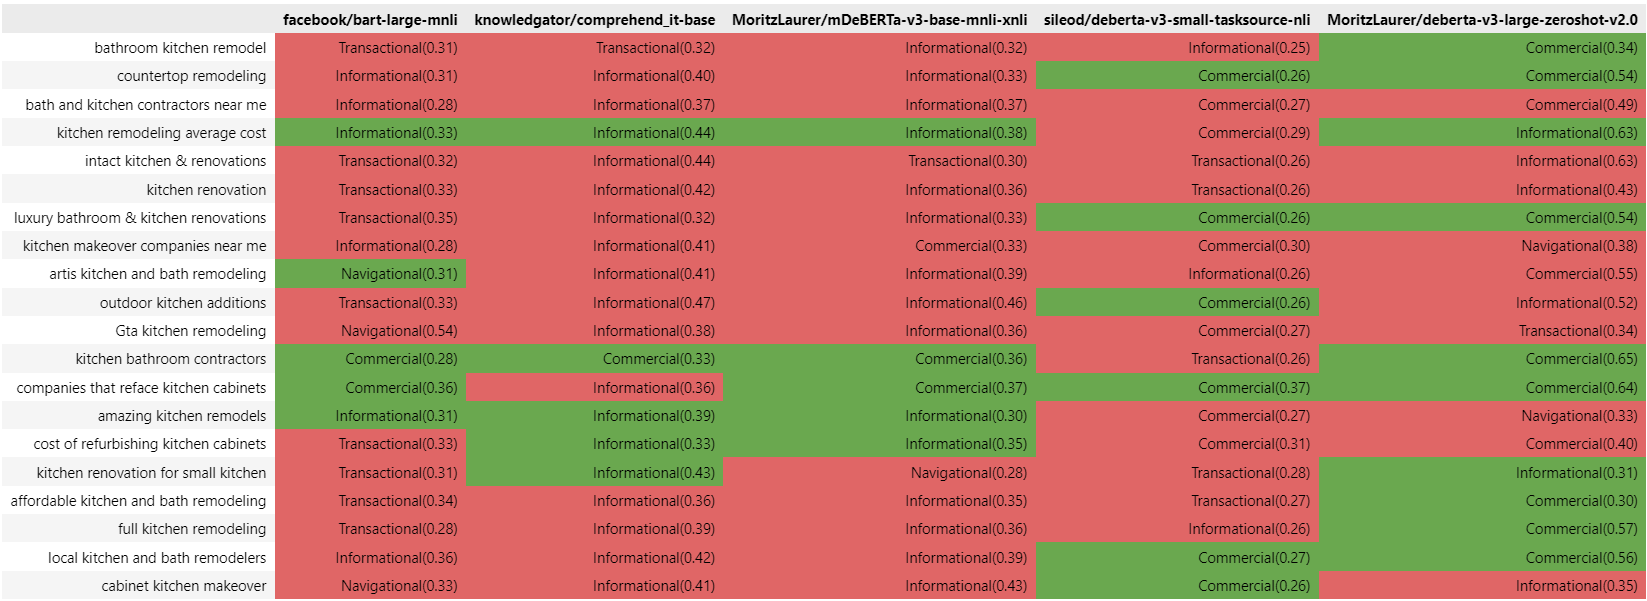

In [ ]:
import spacy
import random

# Load Spacy's English tokenizer, POS tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

fixed_words = ["and", "&", "of", "on", "near", "me", "to", "with", "for", "in", "at", "from", "by", "a", "an"]

def shuffle_query(query):
    # Parse the sentence using the loaded NLP model
    doc = nlp(query)
    
    # Extract the tokens and their POS tags
    tokens = [(token.text, token.pos_) for token in doc]
    
    # Separate the tokens based on POS tags
    nouns = [token for token in tokens if token[1] in ['NOUN', 'PROPN']]
    verbs = [token for token in tokens if token[1] in ['VERB']]
    adjectives = [token for token in tokens if token[1] in ['ADJ']]
    others = [token for token in tokens if token[1] not in ['NOUN', 'PROPN', 'VERB', 'ADJ'] and token[0].lower() not in fixed_words]
    
    # Shuffle each category separately
    random.shuffle(nouns)
    random.shuffle(verbs)
    random.shuffle(adjectives)
    
    # Combine the shuffled tokens back into a query
    shuffled_tokens = verbs + others + nouns + adjectives
    
    # Reconstruct the query while maintaining the position of fixed words
    reconstructed_query = []
    fixed_word_indices = {token.i: token.text for token in doc if token.text.lower() in fixed_words}
    
    for i, token in enumerate(shuffled_tokens):
        if i in fixed_word_indices:
            reconstructed_query.append(fixed_word_indices[i])
        reconstructed_query.append(token[0])
    
    # Ensure that fixed phrases like "near me" and "cost" are preserved
    shuffled_query = ' '.join(reconstructed_query)
    for fixed_phrase in most_common_bigrams:
        if fixed_phrase in query:
            shuffled_query = shuffled_query.replace(fixed_phrase, "")
            shuffled_query += f" {fixed_phrase}"
    
    # Clean up any double spaces
    shuffled_query = ' '.join(shuffled_query.split())
    
    return shuffled_query

def shuffle_queries(queries):
    return [shuffle_query(query) for query in queries]

shuffled_queries = shuffle_queries(low_volume_queries)

shuffled_queries = [query for query in shuffled_queries if query not in low_volume_queries]

print('Number of shuffled queries:', len(shuffled_queries), '\n')
shuffled_queries[:10]


Number of shuffled queries: 475 



['remodel kitchen affordable near me kitchen remodel',
 'contractors kitchen renovation near me',
 'replacement kitchen counter top',
 'contractors bath near me kitchen and and bath',
 'refacing kitchen cost',
 'renovations kitchen cheap kitchen renovation kitchen renovations',
 'remodeling and companies bath kitchen near me kitchen and and bath bath remodeling',
 'bath remodelers and kitchen best near me kitchen and and bath',
 'renovation cabinet kitchen',
 'renovations room kitchen near me kitchen and and bath and bathroom']

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Testing the performance of OpenAI models for classifying the search intent

<u>In this section I present a comparison between the different OpenAI models:</u><br> ['gpt-4o', 'gpt-4', 'gpt-4-turbo', 'gpt-3.5-turbo']<br>

First let's find the proper temperature for the task.

In [54]:
# Labels for display
labels = ['Informational', 'Navigational', 'Transactional', 'Commercial']

def gpt_classify(query, labels, model, tempreture=0):
    explanation = (
        "Classify the following query into one of the search intent types: 'Informational', 'Navigational', 'Transactional', 'Commercial'"
        "Keep the response short in the format 'Label'."
    )
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a professional SEO expert."},
            {"role": "user", "content": f"{explanation} Query: {query}"}
        ],
        max_tokens=50,
        n=1,
        stop=None,
        temperature=tempreture
    )
    label = response.choices[0].message.content.strip()
    # Parse the response to extract the label
    for label_option in labels:
        if label_option in label:
            return label_option
    return "Unclassified"

query = ['amazing kitchen remodels', 'Gta kitchen remodeling']

trmperature = [0, 0.3, 0.5, 0.7, 1]

# Present tempretur results in a table
results = {}
for t in trmperature:
    gpt4o_labels = []
    for q in query:
        label = gpt_classify(q, labels, 'gpt-4o', t)
        gpt4o_labels.append(label)
    results[t] = gpt4o_labels

results_df = pd.DataFrame(results, index=query)
results_df

,0.0,0.3,0.5,0.7,1.0
amazing kitchen remodels,Informational,Informational,Informational,Informational,Commercial
Gta kitchen remodeling,Commercial,Commercial,Commercial,Commercial,Commercial


In the queries above, the gpt-4o model is not correct.<br>
<b>amazing kitchen remodels</b> Should be Informational - so the deterministic approach of 0 temperature shows better results.<br>
While <b>Gta kitchen remodeling</b> 
still gets incorrect classification.

In [32]:
def gpt_classify(query, labels, model, tempreture=0):
    explanation = (
        "Classify the following query into one of the search intent types: 'Informational', 'Navigational', 'Transactional', 'Commercial'"
        "Keep the response short in the format 'Label'."
    )
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a professional SEO expert."},
            {"role": "user", "content": f"{explanation} Query: {query}"}
        ],
        max_tokens=50,
        n=1,
        stop=None,
        temperature=tempreture
    )
    label = response.choices[0].message.content.strip()
    # Parse the response to extract the label
    for label_option in labels:
        if label_option in label:
            return label_option
    return "Unclassified"

In [ ]:
# GPT comparison table use gpt_classify
gpt_models = ['gpt-4o', 'gpt-4', 'gpt-4-turbo', 'gpt-3.5-turbo']

gpt_models_comparison_df = {}
for model_name in gpt_models:
    model_labels = []
    for query in training_queries:
        label = gpt_classify(query, labels, model_name)
        model_labels.append(label)
    gpt_models_comparison_df[model_name] = model_labels

gpt_models_comparison_df = pd.DataFrame(gpt_models_comparison_df, index=training_queries)

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Presenting the performance across some of the OpenAI models 
#### We can see clearly the improvement from model to model where <b>gpt-4o</b> shows very impressive results

In [ ]:
# Apply the highlighting function
styled_gpt_df = gpt_models_comparison_df.style.apply(highlight_cells, axis=1)

# Save the styled dataframe to an HTML file in the current directory
styled_gpt_df.to_html('highlighted_gpt_results.html')

# Display the styled dataframe (if you're using Jupyter Notebook)
styled_gpt_df

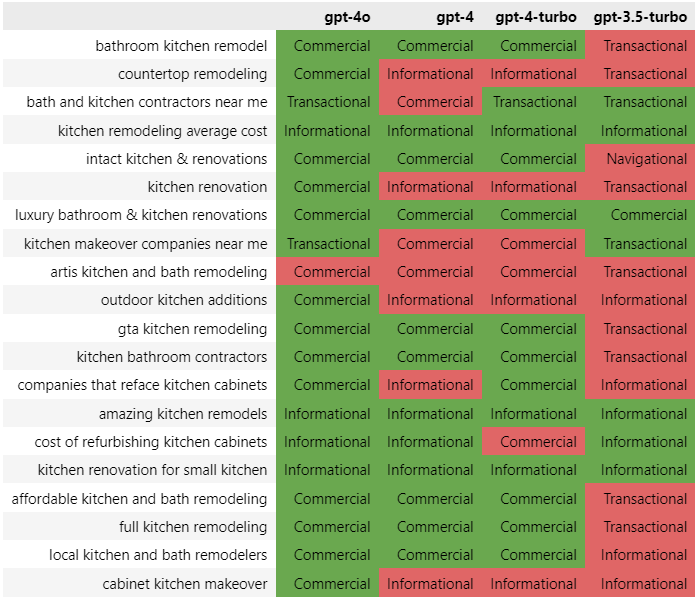

<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Use the best aproach in order to label the queries

#### I used gpt-4o to classify the list of 255 search query I got from Google Ads Keyword Planner<br> The Prosess took around 3 minutes and cost around 0.1$

In [ ]:
# Generate labels for the random sample using GPT-4o in a dictionary format
gpt4o_labels = {}
labels = ['Informational', 'Navigational', 'Transactional', 'Commercial']

for query in keywords_list:
    label = gpt_classify(query, labels, 'gpt-4o', 0)
    gpt4o_labels[query] = label

In [48]:
# Display the labels
sample_labels = {query: gpt4o_labels[query] for query in gpt4o_labels}
sample_labels_df = pd.DataFrame(list(sample_labels.items()), columns=['Query', 'Label'])
labels = ['Informational', 'Navigational', 'Transactional', 'Commercial']

 # Print a sampe of qyeries for each label
for label in labels:
    print(f"'{label}':")
    for i in sample_labels_df[sample_labels_df['Label'] == label]['Query'].sample(5):
        print(i)
    print('\n')

'Informational':
bathroom top resurfacing and notch kitchen
2021 cost of kitchen renovation average
kitchen renovation 2022 cost
removal installation and kitchen
kitchen cabinet restoration


'Navigational':
kitchen bath near me
kitchen bridgewater contractor
kitchen virginia basement bath & northern
modern bathroom company
kitchen and contractors bath near me


'Transactional':
kitchen cabinet renovation near me
contractors kitchen bath near me
kitchens renovations near me
bath & kitchen renovation near me
cabinet refinishers near me


'Commercial':
best kitchen remodel near me
bathroom and kitchen remodel contractors
remodelers kitchen and bath local
refinishers kitchen
contractors for kitchen and bathroom remodeling




<meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">

### <i class="fa fa-thumbs-o-up"></i> Business use case:
#### For a user that is interested in the query <b>"Kitchen remodeling services"</b> I would recommend investing the grated amount of the google search budget in the following keywords that are related to associated with users with the intention of purchasing. 
#### The user might consider using the keywords for the other labels to write content in order to get relevant users into his site.

In [42]:
# Print the list of keywords with the label of Informational
transactional_keywords = [keyword for keyword, label in gpt4o_labels.items() if label == 'Transactional']
print('Number of queries in each category:', '\n')
print('Informational:', len([keyword for keyword, label in gpt4o_labels.items() if label == 'Informational']))
print('Nevigational:', len([keyword for keyword, label in gpt4o_labels.items() if label == 'Navigational']))
print('Transactional:', len([keyword for keyword, label in gpt4o_labels.items() if label == 'Transactional']))
print('Commercial:', len([keyword for keyword, label in gpt4o_labels.items() if label == 'Commercial']))
print('\n')
print('Sample of Transactional queries:')
random.sample(transactional_keywords, 10)

Number of queries in each category: 

Informational: 80
Nevigational: 6
Transactional: 57
Commercial: 112


Sample of Transactional queries:


['kitchen replacement countertops near me',
 'cost kitchen renovation full',
 'kitchen cabinet remodeling near me',
 'redo kitchen cabinets',
 'cost resurfacing cabinet kitchen',
 'services bathroom complete',
 'kitchen cabinets remodeling near me',
 'kitchen remodel near me',
 'cost to replace kitchen cabinets',
 'local contractors kitchen near me']

### <i class="fa fa-thumbs-o-up"></i> Technical notes and future actions:
#### The project presents a concept strategy for searching and classifying the best search queries given an initial query related to a specific business. <br> There are some other steps that need to be done in order to refine the project so it will be used in real business when the main step is to ensure the results of each step, manually tag more queries, and create a one-shot classifier rather than a zero-shot classifier.<br> After labeling, and generating data using the gpt-4o model, we could train RNN model and use it for the search intent classification and save the expensive API calls for OpenAI.